<a href="https://colab.research.google.com/github/Somertonman/hackathon_2023/blob/main/graph_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [30]:
!pip install pymorphy2
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%%capture
!pip install python-docx docx

In [ ]:
!pip install transformers sacremoses
from transformers import pipeline

qa_pipeline = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

In [4]:
import pandas as pd
import spacy
from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [22]:
!python -m spacy download ru_core_news_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-21 13:52:37.553719: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


# Data source

In [3]:
!wget https://github.com/Somertonman/hackathon_2023/raw/main/all_parsed_graph.csv

--2023-01-21 13:09:45--  https://github.com/Somertonman/hackathon_2023/raw/main/all_parsed_graph.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Somertonman/hackathon_2023/main/all_parsed_graph.csv [following]
--2023-01-21 13:09:46--  https://raw.githubusercontent.com/Somertonman/hackathon_2023/main/all_parsed_graph.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1697789 (1.6M) [text/plain]
Saving to: ‘all_parsed_graph.csv.2’

all_parsed_graph.cs 100%[===================>]   1.62M  --.-KB/s    in 0.06s   

2023-01-21 13:09:46 (27.4 MB/s) - ‘all_parsed_graph.csv.2’ saved [1697789/1697789]

In [5]:
df = pd.read_csv('all_parsed_graph.csv')
df = df.query('name != "себя"').reset_index().drop(columns='index')
df = df[['id', 'task_num',
       'task_text', 'dept', 'task_responsibles_people', 'task_deadline',
       'position', 'name', 'global_deadline', 'Tasks']]
df.head()

,id,task_num,task_text,dept,task_responsibles_people,task_deadline,position,name,global_deadline,Tasks
0,0,Task1,Закупить книги. Срок завершения: 19 апр 15.,Административно-хозяйственный отдел,Ответственность за исполнение распоряжения воз...,2015-04-18,специалист первый категория административно-хо...,кравцов и.е.,2013-04-10,NaN
1,1,Task1,Провести анализ поставщиков для замены вышедше...,Служба ИТ,Ответственность за исполнение распоряжения воз...,2012-10-23,специалист третий категория служба ит,ким ю.и.,2013-06-02,NaN
2,1,Task2,Выполнить ремонт кабеля сети передачи данных м...,Служба ИТ,Контроль над выполнением приказа возложить на ...,2013-08-11,системный администратор,сергеев а.,2013-06-02,NaN
3,1,Task3,Создать и настроить виртуальную машину в соотв...,Служба ИТ,Контроль над исполнением распоряжения оставить...,2019-09-09,специалист третий категория,ким ю.и.,2013-06-02,NaN
4,2,Task1,Провести рефакторинг программного обеспечения ...,Отдел разработки систем,Контроль над исполнением распоряжения оставить...,2020-12-23,контроль над исполнение распоряжение,абаимов с.,2014-10-07,NaN


In [68]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian") 

def Convert(string): 
    li = list(string.split(" ")) 
    return li 

def stem(text):
  my_words = Convert(text)
  l = []
  for word in my_words:
    if word != "специалист":
        l.append(stemmer.stem(word))
  return " ".join(l)

In [69]:
df['position'] = df.apply(lambda x: stem(x['position']), axis=1)

In [70]:
df['position']

0       перв категор административно-хозяйствен отдел
1                               трет категор служб ит
2                               системн администратор
3                                        трет категор
4                     контрол над исполнен распоряжен
                            ...                      
2864    перв категор административно-хозяйствен отдел
2865     руководител административно-хозяйствен отдел
2866    перв категор административно-хозяйствен отдел
2867     руководител административно-хозяйствен отдел
2868     руководител административно-хозяйствен отдел
Name: position, Length: 2869, dtype: object

#spaCy

In [8]:
# https://drive.google.com/file/d/1GIak7jmxhucwpr4VAJxEniinMwOmObPv/view?usp=sharing
!gdown 1GIak7jmxhucwpr4VAJxEniinMwOmObPv

Downloading...
From: https://drive.google.com/uc?id=1GIak7jmxhucwpr4VAJxEniinMwOmObPv
To: /content/json.tar
100% 56.1M/56.1M [00:00<00:00, 259MB/s]


In [ ]:
!mkdir json_dataset
!tar -xvf  '/content/json.tar' -C '/content/json_dataset'

In [10]:
def parse_file(file_name, num):
  df = pd.read_json(file_name).reset_index()

  df['id'] = num

  df = df.query('index not in ("Global_deadline", "Global_supervisor")')
  df['task_text'] = df.apply(lambda x: x['Tasks']['task_text'], axis = 1)
  df['task_responsibles_people'] = df.apply(lambda x: x['Tasks']['task_responsibles_people'], axis = 1)
  df['task_responsibles_groups'] = df.apply(lambda x: x['Tasks']['task_responsibles_groups'], axis = 1)

  df = df[['id', 'index', 'task_responsibles_groups', 'task_responsibles_people']]
  return df.rename(columns={'index':'task_num', 'task_responsibles_groups':'dept'})

In [11]:
df_emp = parse_file('/content/json_dataset/json/0.json', 0)

for i in tqdm(range (1, 10000)):
  file_name = f"/content/json_dataset/json/{i}.json"
  df_one = parse_file(file_name, i)
  df_emp = pd.concat([df_emp, df_one])

df_emp['task_responsibles_people'] = df_emp['task_responsibles_people'].str.lower()
df_emp = df_emp.reset_index().drop(columns=['index'])
df_emp.head()

100%|██████████| 9999/9999 [02:52<00:00, 58.08it/s]


,id,task_num,dept,task_responsibles_people
0,0,Task1,Административно-хозяйственный отдел,ответственность за исполнение распоряжения воз...
1,1,Task1,Служба ИТ,ответственность за исполнение распоряжения воз...
2,1,Task2,Служба ИТ,контроль над выполнением приказа возложить на ...
3,1,Task3,Служба ИТ,контроль над исполнением распоряжения оставить...
4,2,Task1,Отдел разработки систем,контроль над исполнением распоряжения оставить...


In [12]:
df_emp_n = df_emp.head(100)

In [23]:
nlp = spacy.load("ru_core_news_lg")

In [15]:
df_emp_n['name'] =  df_emp_n.apply(lambda x : ' '.join([ent.text for ent in nlp(x.task_responsibles_people).ents]), axis = 1)
df_emp_n.head()

,id,task_num,dept,task_responsibles_people,name
0,0,Task1,Административно-хозяйственный отдел,ответственность за исполнение распоряжения воз...,кравцову и.е.
1,1,Task1,Служба ИТ,ответственность за исполнение распоряжения воз...,ит
2,1,Task2,Служба ИТ,контроль над выполнением приказа возложить на ...,сергеева андрея
3,1,Task3,Служба ИТ,контроль над исполнением распоряжения оставить...,ит
4,2,Task1,Отдел разработки систем,контроль над исполнением распоряжения оставить...,абаимовым симоном


# Data cleaning

In [16]:
df.fillna(0, inplace = True)
df.replace('None', 0, inplace = True)


# EDA

In [7]:
# some basic stats

documents = df['id'].unique()
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()


print('Number of docs:', len(documents))
print('Number of depts in the company:', len(departments) )
print('Number of employees in the company:', len(employees))
print('Number of positions in the company total:', len(positions))

Number of docs: 620
Number of depts in the company: 8
Number of employees in the company: 46
Number of positions in the company total: 62


## How many documents was analyzed?

## Company departments

In [18]:
print(departments)

['Административно-хозяйственный отдел' 'Служба ИТ'
 'Отдел разработки систем' 'Отдел архитектуры' 'Бухгалтерия'
 'Отдел проектирования' 'Отдел эксплуатации' 'Отдел тестирования']


## Employees

In [19]:
print(employees)

['кравцов и.е.' 'ким ю.и.' 'сергеев а.' 'абаимов с.' 'абашкин о.'
 'абалкин з.' 'андреев с.е.' 'слесарев а.в' 'абатуров б.' 'миронов к.а.'
 'симонов н.с.' 'абаков а.' 'попов а.а.' 'никишин с.е.' 'абашичев а.'
 'галкин c.c.' 'сергеева а.и.' 'поспелов н.а.' 'миронов т.п.'
 'александров а.с.' 'семёнов м.с.' 'миронов т.п' 'миронов и.а'
 'семёнов и.а.' 'попов и.и.' 'коптелов е.в' 'смирнов о.а.' 'шихов р.п.'
 'абакулов п.' 'абалаков с.' 'ведерников и.с.' 'жуков а.в' 'точнов с.о.'
 'иванов а.а.' 'артюхин р.е.' 'александров а.и.' 'абалдуев о.'
 'петров в.м.' 'никитина и.п.' 'андреев к.с.' 'абалакин м.'
 'абакумов глеб' 'львов а.м.' 'анненков и.с.' 'спецов а.в' 'янин и.а.']


In [20]:
emp_dictionary = { emp : emp for emp in employees }
emp_dictionary['янина и.а.'] = 'янин и.а.'
emp_dictionary['ким юрий иванович'] = 'ким ю.и.'
emp_dictionary['абаимов симона'] = 'абаимов с.'
emp_dictionary['абаимов симон'] = 'абаимов с.'
emp_dictionary['сергеев андрей'] = 'сергеев а.'
emp_dictionary['абашкин орест'] = 'абашкин о.'
emp_dictionary['абалкин зураб'] = 'абалкин з.'
emp_dictionary['абатуров борис'] = 'абатуров б.'
emp_dictionary['симоново н.с.'] = 'симонов н.с.'
emp_dictionary['абаковый алексей'] = 'абаков а.'
emp_dictionary['абашичев алексей'] = 'абашичев а.'
emp_dictionary['с.с.галкин'] = 'галкин c.c.'
emp_dictionary['сергеев ален иванович'] = 'сергеева а.и.'
emp_dictionary['семёнов'] = 'семёнов и.а.'
emp_dictionary['кравцов'] = 'кравцов и.е.'
emp_dictionary['шихов'] = 'шихов р.п.'
emp_dictionary['абакуловый пётр'] = 'абакулов п.'
emp_dictionary['абалаково севастьян'] = 'абалаков с.'
emp_dictionary['артюхин'] = 'артюхин р.е.'
emp_dictionary['александров александр иванович'] = 'александров а.и.'
emp_dictionary['абалаковый севастьян'] = 'абалаков с.'
emp_dictionary['абалдуев олег'] = 'абалдуев о.'
emp_dictionary['никитин ирина петрович'] = 'никитина и.п.'
emp_dictionary['абалакин михаил'] = 'абалакин м.'
emp_dictionary['сергеев алёна иванович'] = 'сергеева а.и.'
emp_dictionary['петров'] = 'петров в.м.'
emp_dictionary['львов'] = 'львов а.м.'
emp_dictionary['абаков алексей'] = 'абаков а.'
emp_dictionary['анненков'] = 'анненков и.с.'
emp_dictionary['точновый'] = 'точнов с.о.'
emp_dictionary['спецова а.в'] = 'спецов а.в'
emp_dictionary['миронов'] = 'миронов т.п'
emp_dictionary['семёнов'] = 'миронов и.а'
emp_dictionary['коптеловый е.в'] = 'коптелов е.в'
emp_dictionary['точновое с.о.'] = 'точнов с.о.'
emp_dictionary['р.е.артюхин'] = 'артюхин р.е.'

In [ ]:
df['name'] = df['name'].map(emp_dictionary)

# Graph

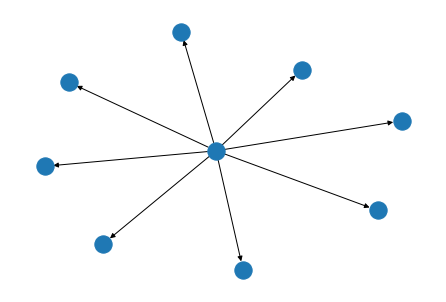

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

DG = nx.DiGraph()

comp_name = 'COMPANY'

for i in list(departments):
    DG.add_edge(comp_name, i)
    

nx.draw(DG)


## Multilevel graph

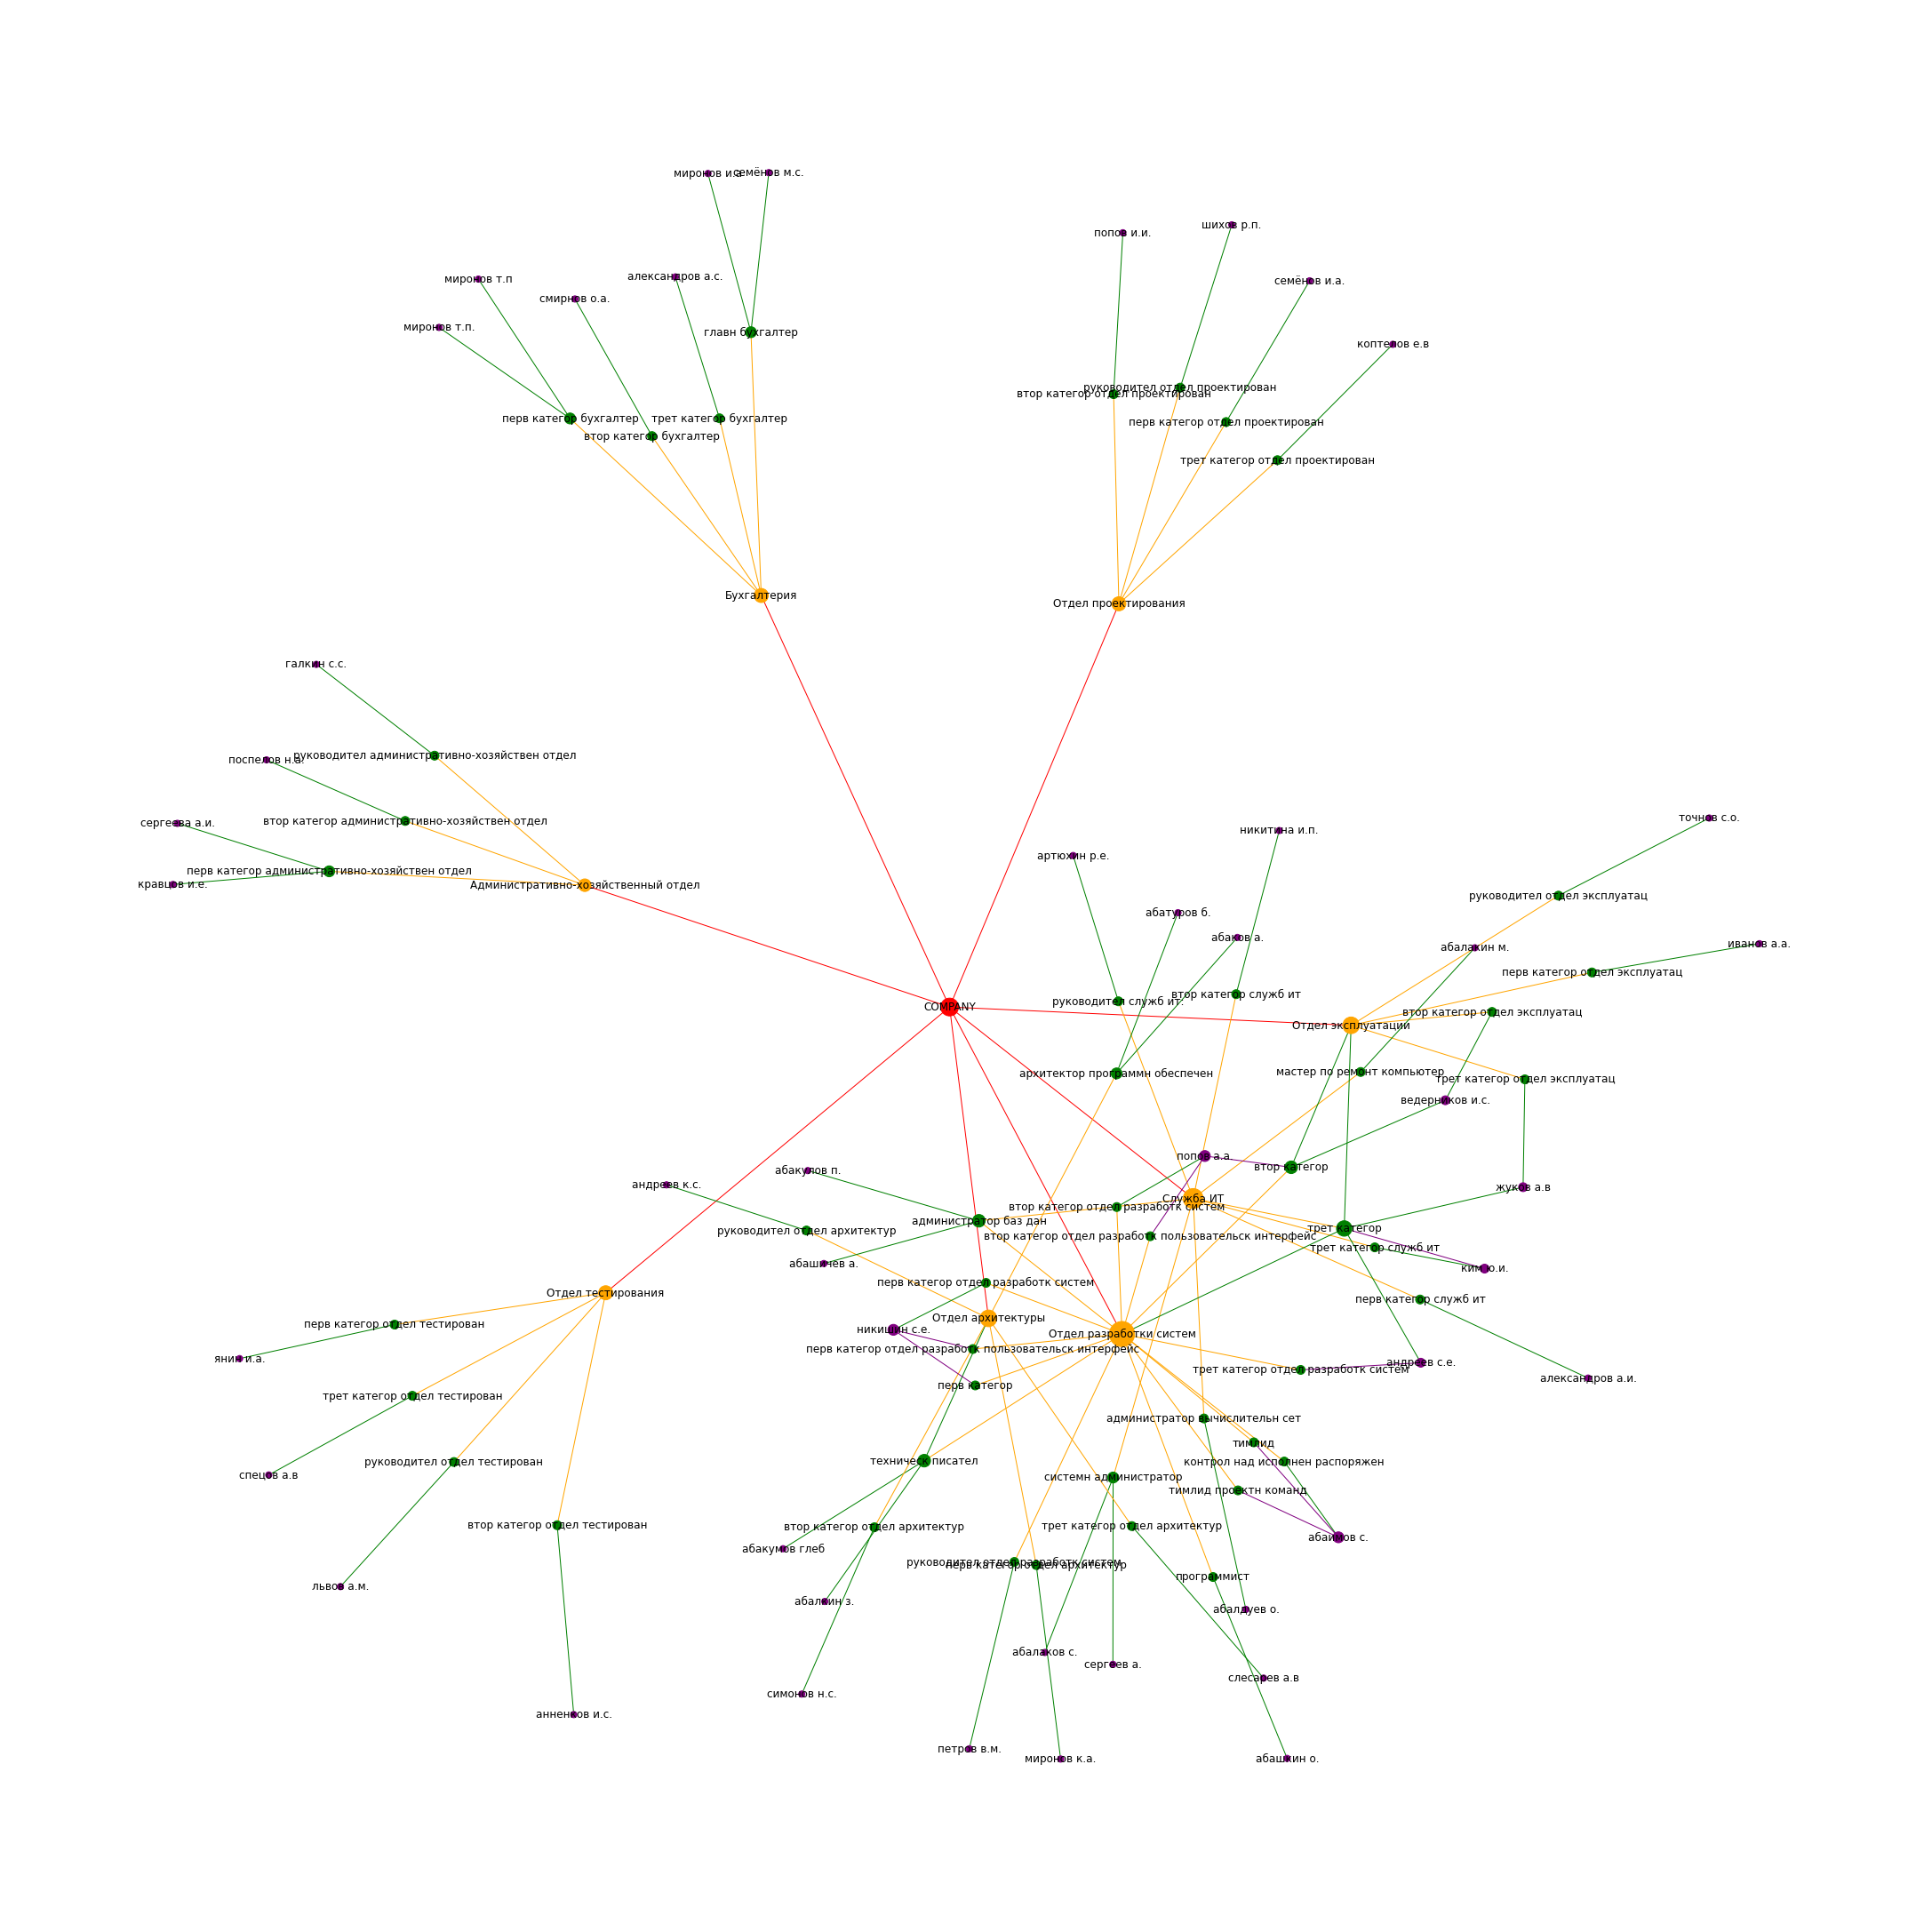

In [71]:
# create a graph object
G = nx.Graph()

comp_name = 'COMPANY'

for z in list(departments):
    G.add_edge(comp_name, z)
    # iterate through the rows of the DataFrame
    for i, row in df.iterrows():
        # add task_responsibles_groups node
        dept = row["dept"]
        G.add_node(dept, size=df["dept"].value_counts()[dept])
        # add position node
        position = row["position"]
        G.add_node(position, size=df["position"].value_counts()[position])
        # add name node
        name = row["name"]
        G.add_node(name, size=df["name"].value_counts()[name])
        # add edges between task_responsibles_groups and position
        G.add_edge(dept, position)
        # add edges between position and name
        G.add_edge(position, name)

# draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
pos = nx.spring_layout(G) # spring layout to calculate node positions

# create a list of node sizes
node_sizes = []
for node in G.nodes():
    node_sizes.append(G.degree(node)*50)

# create a list of node colors
node_colors = []
for node in G.nodes():
    if node in departments:
        node_colors.append("orange")
    elif node in df["position"].unique():
        node_colors.append("green")
    elif node in df["name"].unique():
        node_colors.append("purple")
    else:
        node_colors.append("red")

# create a list of edge colors
edge_colors = []
for edge in G.edges():
    if edge[0] in departments:
        edge_colors.append("orange")
    elif edge[0] in df["position"].unique():
        edge_colors.append("green")
    elif edge[0] in df["name"].unique():
        edge_colors.append("purple")
    else:
        edge_colors.append("red")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors)


# Document checker

In [ ]:
from google.colab import files

!test -d docx_for_check || mkdir docx_for_check

uploaded = files.upload()

print('uploaded to the "/content" folder')

In [ ]:
!unzip /content/docx.zip

## Parsing text from docx files

In [20]:
from docx import Document
import os
import random

def get_text(filename):
    doc = Document(f'/content/docx/{filename}')
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

folder_path = '/content/docx/'
docx_files = [f for f in os.listdir(folder_path) if f.endswith('.docx')]
random_file = random.choice(docx_files)

text = get_text(random_file)
if docx_files:
    random_file = random.choice(docx_files)
    text = get_text(random_file)
    print(text)
else:
    print("No docx files found in the directory")



Отдел внедрения Департамента внедрения и обслуживания



Информационное сообщение

В связи с окончанием проекта "Внедрение системы знаний" поручаю обеспечить выполнение задач:
○ пункт 5.1.2 дополнить абзацем четвертым следующего содержания:
"При официальной переписке с межгосударственными (международными) органами, компетентными органами и должностными лицами иностранных государств, иностранными гражданами и организациями используется отдельный бланк с продольным расположением реквизитов на двух языках - русском и английском (приложение N 61)." Определить срок исполнения задачи вплоть до 0.
Контроль над выполнением вышеуказанного поручения возложить на Контент менеджера Олабухина Этьена.

	i) Дополнить новым подпунктом 10.6 следующего содержания:
"10.6. Осуществление контроля качества предоставления государственных услуг и обеспечения их доступности по линии безопасности дорожного движения.". Приступить к исполнению поручения до 21 июня 2015 г..
Ответственность за исполнение задачи во

In [25]:
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

In [31]:
def im_pad(text):
  morph = pymorphy2.MorphAnalyzer()
  words = text.split()
  nominative_words = []
  for word in words:
    parsed_word = morph.parse(word)[0]
    nominative_word = parsed_word.normal_form
    nominative_words.append(nominative_word)
  nominative_sentence = " ".join(nominative_words)
  return nominative_sentence

In [59]:
def name_to_initials(full_name):
    if not full_name:
        return ""
    if '.' in full_name:
        return full_name
    name_parts = full_name.split()
    lastname = name_parts[0]
    initials = "".join([part[0] + "." for part in name_parts[1:]])
    return lastname + " " + initials

In [60]:
doc = nlp(text)
names = []
for ent in doc.ents:
    if ent.label_ == "PER":
        names.append(ent.text)

dict_emp = {}
for i in names:
    dict_emp[name_to_initials(i.lower()).replace(". ", ".")] = im_pad(qa_pipeline(f"Какая должность у {i}?", text)['answer'])

dict_emp

{'олабухина э.': 'контент менеджер',
 'хромеца м.': 'контент менеджер',
 'турова с.': 'администратор вычислительный сеть',
 'роговцова б.': 'администратор вычислительный сеть',
 'климов п.к.': 'администратор вычислительный сеть'}

### Check a given name and position on the graph

In [43]:
import pymorphy2
def is_name_position_in_graph(G, name, position):
    if not name and not position:
        return False
    morph = pymorphy2.MorphAnalyzer()
    if name:
        name_norm = morph.parse(name)[0].normal_form
    if position:
        position_norm = morph.parse(position)[0].normal_form

    for node in G.nodes():
        if name:
            node_norm = morph.parse(node)[0].normal_form
            if node_norm != name_norm:
                continue
        if position:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                neighbor_norm = morph.parse(neighbor)[0].normal_form
                if neighbor_norm == position_norm:
                    return True
    return False


In [72]:
for i in range(len(list(dict_emp.values()))):
    print("name: ", list(dict_emp)[i], " | ",
          "position: ", list(dict_emp.values())[i], " | ",
          "result: ", is_name_position_in_graph(G, list(dict_emp)[i], list(dict_emp.values())[i]))
    # print(is_name_position_in_graph(G, list(dict_emp)[i], list(dict_emp.values())[i]))

name:  олабухина э.  |  position:  контент менеджер  |  result:  False
name:  хромеца м.  |  position:  контент менеджер  |  result:  False
name:  турова с.  |  position:  администратор вычислительный сеть  |  result:  False
name:  роговцова б.  |  position:  администратор вычислительный сеть  |  result:  False
name:  климов п.к.  |  position:  администратор вычислительный сеть  |  result:  False


In [73]:
name = 'семёнов м.с.'
position = 'главн бухгалтер'
print(is_name_position_in_graph(G, name, position))

True


# Graph finding paths

In [74]:
results = []
for n1 in G.nodes():
    for n2 in G.nodes():
        shortest_path = nx.single_source_dijkstra(G, source=n1, target=n2)
        results.append(shortest_path)


In [75]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)


(3, ['ведерников и.с.', 'втор категор отдел эксплуатац', 'Отдел эксплуатации', 'COMPANY'])


# Helper functions

In [76]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)

(3, ['ведерников и.с.', 'втор категор отдел эксплуатац', 'Отдел эксплуатации', 'COMPANY'])


Is a given person works in the company

In [77]:
def is_employee(graph, company, name):
  try:
    shortest_path = nx.single_source_dijkstra(G, source=company, target=name)
    print(shortest_path)
    if shortest_path[0] == 3 and shortest_path[1][-1] == name:
      return True
    else:
      return False
  except:
    return False

is_employee(G, 'COMPANY', 'ведерников и.с.')

(3, ['COMPANY', 'Отдел разработки систем', 'втор категор', 'ведерников и.с.'])


True

In [81]:
is_employee(G, 'COMPANY', 'абатуров б.')

(3, ['COMPANY', 'Отдел архитектуры', 'архитектор программн обеспечен', 'абатуров б.'])


True

In [82]:
is_employee(G, 'COMPANY', 'обатуров б.')

False

Is a given person works in the company